In [1]:
from ipywidgets import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_profiling as pp
import os
import glob
import sys
from sksurv.linear_model import CoxPHSurvivalAnalysis

plt.rcParams["figure.figsize"] = [10,10]
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use(BACKEND)


In [3]:
def filter_data(df , columns):
    first_idx = df.groupby("Name")[columns].apply(lambda x: x.first_valid_index()[1])
    first_idx = first_idx.to_frame("Time")

    last_idx = df.groupby("Name")[columns].apply(lambda x: x.last_valid_index()[1])
    last_idx= last_idx.to_frame("Time")

    nd1 = pd.DataFrame()
    nd2 = pd.DataFrame()
    nd1 = df.loc[(subjects[0]),:][first_idx["Time"][subjects[0]]:last_idx["Time"][subjects[0]]]
    nd1["Name"] = subjects[0]

    nd2 = df.loc[(subjects[1]),:][first_idx["Time"][subjects[1]]:last_idx["Time"][subjects[1]]]
    nd2["Name"] = subjects[1]

    concat_data = pd.concat((nd1,nd2))
    
    for s in subjects[2:]:
        nd = pd.DataFrame()
        nd = df.loc[(s),:][first_idx["Time"][s]:last_idx["Time"][s]]
        nd["Name"] = s
        concat_data = pd.concat((concat_data,nd))
    
    concat_data.set_index("Name", append = True ,inplace=True)
    concat_data = concat_data.reorder_levels(['Name','Time'])
    
    return concat_data

# Read concatenated data about temperature and gas analysis

In [4]:
# read df
raw_df = pd.read_csv("./data/filtered_and_avereged_data.csv")
raw_df['Time'] = pd.to_timedelta(raw_df['Time'])
raw_df.set_index(["Name","Time"],inplace = True)
raw_df.interpolate(inplace = True)
#raw_df.dropna(inplace=True)

# set lists variables
fat_cols = ['FAT  [g/day]', 'CHO  [g/day]']
all_temp_cols = ["TLE", "TRE", "TLA", "TRA", "TLL", "TRL"]
temp_cols = ['TLE', 'TRE']
subjects = np.array(list(set(raw_df.index.get_level_values("Name"))))

#filter data
concat_data = filter_data(raw_df, ["Ph"])
concat_data = filter_data(concat_data, ['FAT  [g/day]'])
concat_data = concat_data.drop(columns=["Ph"])
raw_df.dropna(inplace=True)

full_df = concat_data.copy()
full_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13535 entries, (MALEJIK, 0 days 00:06:07) to (TUNIK, 0 days 00:15:00)
Data columns (total 14 columns):
TLE                    13535 non-null float64
TRE                    13535 non-null float64
TLA                    13535 non-null float64
TRA                    13535 non-null float64
TLL                    13535 non-null float64
TRL                    13535 non-null float64
Load  [W]              13535 non-null float64
HR  [1/min]            13535 non-null float64
VO2/kg  [ml/min/kg]    13535 non-null float64
RER                    13535 non-null float64
V'O2  [ml/min]         13535 non-null float64
V'CO2  [ml/min]        13535 non-null float64
FAT  [g/day]           13535 non-null float64
CHO  [g/day]           13535 non-null float64
dtypes: float64(14)
memory usage: 1.5+ MB


# Read inforamation about examples

In [6]:
def read_general_df(path):
    
    #general info
    raw_df = pd.read_csv(path + '.XLO', engine='python', sep='\t', header=None, nrows=10, skipinitialspace=True, encoding="windows-1251")      
    cols = [i.split(':', 1)[0]  for i in list(raw_df[0]) + list(raw_df[2][:-1])]
    values = list(raw_df[1]) + list(raw_df[3][:-1])
    
    return pd.DataFrame(data = np.array(values).reshape(1,-1), columns = cols)
files = glob.glob('data/**/*.XLO')
paths = [file.split('.')[0] for file in files]
general_dfs = {subject: read_general_df(path) for (subject, path) in zip(subjects, paths)}


df_for_prob = pd.DataFrame()
weight = []
height = []
age = []
sex = []
for i in subjects:
    W = general_dfs[i]["Rel. Weight"].str.split()[0][0]
    A = general_dfs[i].Age.str.split()[0][0]
    H = general_dfs[i].Height.str.split()[0][0]
    weight.append(float(W)/100)
    height.append(float(H)/200)
    age.append(float(A)/100)
    sex.append(general_dfs[i].Sex.str.split()[0][0])    
df_for_prob["Subjects"] = subjects
df_for_prob.set_index("Subjects", inplace=True)
df_for_prob["Weight"] = weight
df_for_prob["Height"] = height
df_for_prob["Age"] =age
df_for_prob["sex"] =sex
df_for_prob = pd.get_dummies(df_for_prob, prefix = "sex")

df_for_prob.head()

,Weight,Height,Age,sex_female,sex_male
Subjects,,,,,
MALEJIK,0.85,0.835,0.33,0,1
DANILOV,0.88,0.860,0.28,0,1
DREMAREC,0.80,0.935,0.38,0,1
GLEB,0.87,0.870,0.22,0,1
JURAKOVSK,0.77,0.865,0.20,0,1


# Show raw data

In [8]:
def show_plots(data_frame, cols, subject, kind = "line", second_data_frame = None, second_data_frame_cols = None):
    if second_data_frame is not None:
        second_data_frame.xs(subject,level=0).plot(figsize=(20, 7), y=second_data_frame_cols)
    data_frame.xs(subject,level=0).plot(figsize=(20, 7), y=cols, grid = True, kind = kind)

def show_data(data_frame, cols, kind = "line", second_data_frame = None, second_data_frame_cols = None):
    sub = SelectionSlider(options=subjects)
    interact(lambda subject: show_plots(data_frame, cols,subject, kind, second_data_frame, second_data_frame_cols), subject=sub)
    
show_data(concat_data, fat_cols)

interactive(children=(SelectionSlider(description='subject', options=('MALEJIK', 'DANILOV', 'DREMAREC', 'GLEB'…

# normalize and smooth data

In [10]:
def normalize(df, cols):
    for name in subjects:
        df.loc[(name),cols] = df.loc[(name),cols].apply(lambda x:(x-x.mean())/x.std()).values
        
def smoothing(window_size, df, cols):
    for name in subjects:
        df.loc[(name),cols] = df.loc[(name),cols].rolling(window=window_size, min_periods = 1, center=True).mean().values

In [11]:
#normalize + smooth
smoothing(window_size = 30, df = full_df,cols =  fat_cols)
normalize(full_df, fat_cols)
smoothing(window_size = 30, df = full_df,cols =  fat_cols)

show_data(full_df, fat_cols, "line", concat_data, fat_cols)

interactive(children=(SelectionSlider(description='subject', options=('MALEJIK', 'DANILOV', 'DREMAREC', 'GLEB'…

# Difference between FAt and CHO consumption

In [12]:
#add different beetween CHO/FAT
full_df["DIFF_FAT_CHO"] = full_df['FAT  [g/day]'] - full_df['CHO  [g/day]']

window_size = 30
normalize(full_df, ["DIFF_FAT_CHO"])
smoothing(window_size, full_df, ["DIFF_FAT_CHO"])

show_data(full_df, "DIFF_FAT_CHO")

interactive(children=(SelectionSlider(description='subject', options=('MALEJIK', 'DANILOV', 'DREMAREC', 'GLEB'…

# Time when type of energy consunption changes

In [14]:
epsilon = 0.7

full_df["y"] = (full_df["DIFF_FAT_CHO"] >= epsilon).astype(int)
def clean(index, subj = subjects):
    for name in subj:
        col = full_df.loc[(name),["y"]].values
        idx_max = col[index:].argmax() + index
        col[:idx_max] = 1
        full_df.loc[(name),["y"]] = col  
        
clean(0)
clean(120, ["VICTOR","PRIYMACHU", "GRIGORCHU"])
clean(250, ["FOKIN"])


show_data(full_df, "y", "line", concat_data , fat_cols)

interactive(children=(SelectionSlider(description='subject', options=('MALEJIK', 'DANILOV', 'DREMAREC', 'GLEB'…

# Survival analysis

## Probability that energy consumption doesn't change

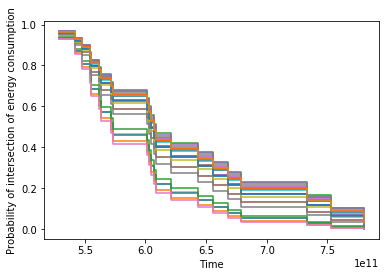

In [15]:
sur = []
for s in subjects:
    sur.append(full_df.xs(s)["y"].idxmin())
df_sur = pd.DataFrame()
df_sur["Subjects"] = subjects
df_sur.set_index("Subjects", inplace=True)
df_sur["event"] = [True] * len(sur)
df_sur["time"] = sur
sur = pd.melt(df_sur, id_vars="event").drop(columns = ["variable"]).to_records(index = False)

#survival analises
estimator = CoxPHSurvivalAnalysis(alpha=0.5)
estimator.fit(df_for_prob, sur)

pred_surv = estimator.predict_survival_function(df_for_prob[:])
for i, c in enumerate(pred_surv):
    plt.step(c.x, (c.y), where="post", label="Sample %d" % (i + 1))
plt.rcParams["figure.figsize"] = [13,10]
plt.ylabel("Probability of intersection of energy consumption")
plt.xlabel("Time")
plt.savefig("./plots/prob.png")
#plt.rcParams["figure.figsize"] = [10,10]
#plt.legend(loc="best")

## add probability column 

In [18]:
res_df = pd.DataFrame(columns=["Time","Name","Probability"])
for s in subjects:     
    dd = pd.DataFrame()
    pred = estimator.predict_survival_function(df_for_prob.loc[s])
    dd["Time"] = pred[0].x
    dd["Name"] = s
    dd["Probability"] = pred[0].y
    res_df = pd.concat([res_df,dd])
res_df
res_df.set_index(["Name","Time"], inplace = True)

#add probability column
full_df = full_df.merge(res_df, on = ["Name","Time"], how = "outer")
full_df.sort_index(inplace = True)
for name in subjects:
    full_df.loc[(name),["Probability"]] = full_df.loc[(name),["Probability"]].fillna(method = 'bfill').values
    full_df.loc[(name),["Probability"]] = full_df.loc[(name),["Probability"]].fillna(method = 'ffill').values
full_df.dropna(inplace = True)

#add column time
full_df["Time_feature"] = pd.to_numeric(full_df.reset_index("Time")["Time"].values)/ (60**2 * 10**9)
#normalize(full_df, ["Time_feature"])

full_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13535 entries, (ARHIPCHUK, 0 days 00:06:05) to (YAN, 0 days 00:16:00)
Data columns (total 18 columns):
TLE                    13535 non-null float64
TRE                    13535 non-null float64
TLA                    13535 non-null float64
TRA                    13535 non-null float64
TLL                    13535 non-null float64
TRL                    13535 non-null float64
Load  [W]              13535 non-null float64
HR  [1/min]            13535 non-null float64
VO2/kg  [ml/min/kg]    13535 non-null float64
RER                    13535 non-null float64
V'O2  [ml/min]         13535 non-null float64
V'CO2  [ml/min]        13535 non-null float64
FAT  [g/day]           13535 non-null float64
CHO  [g/day]           13535 non-null float64
DIFF_FAT_CHO           13535 non-null float64
y                      13535 non-null float64
Probability            13535 non-null float64
Time_feature           13535 non-null float64
dtypes: float64(18)

In [20]:
show_data(full_df, ["y","Probability"])

interactive(children=(SelectionSlider(description='subject', options=('MALEJIK', 'DANILOV', 'DREMAREC', 'GLEB'…

# Normalize temperature by subtracting first temp for each column and each example

In [22]:
full_df_norm = full_df.copy()

for name in subjects:
    full_df_norm.loc[(name),all_temp_cols] = full_df_norm.loc[(name),all_temp_cols].apply(lambda x:(x-x[0])).values
    
    

In [23]:
show_data(full_df_norm, ["y"] + all_temp_cols[2:4], "line", concat_data , fat_cols)

interactive(children=(SelectionSlider(description='subject', options=('MALEJIK', 'DANILOV', 'DREMAREC', 'GLEB'…

# Plots of distrubution

In [27]:
plt.rcParams["figure.figsize"] = [10,10]
full_df["DIFF_FAT_CHO"].groupby("Name").plot(style='g.')
plt.ylabel('DIFF_FAT_CHO')

In [25]:
sub = SelectionSlider(options=subjects)
interact(lambda subject: sns.pairplot(full_df_norm.xs(subject)[temp_cols + fat_cols]), subject=sub)
# for sub in subjects:
#     sns_plot = sns.pairplot(full_df_norm.xs(sub)[temp_cols + fat_cols])
#     sns_plot.savefig("./plots/pairplots/ears/" + sub +".png")

interactive(children=(SelectionSlider(description='subject', options=('MALEJIK', 'DANILOV', 'DREMAREC', 'GLEB'…

<function __main__.<lambda>(subject)>

In [26]:
sub = SelectionSlider(options=subjects)
interact(lambda subject: sns.pairplot(full_df_norm.xs(subject)[all_temp_cols[2:4] + fat_cols]), subject=sub)
# for sub in subjects:
#     sns_plot = sns.pairplot(full_df_norm.xs(sub)[all_temp_cols[2:4] + fat_cols])
#     sns_plot.savefig("./plots/pairplots/arms/" + sub +".png")

interactive(children=(SelectionSlider(description='subject', options=('MALEJIK', 'DANILOV', 'DREMAREC', 'GLEB'…

<function __main__.<lambda>(subject)>

In [27]:
sub = SelectionSlider(options=subjects)
interact(lambda subject: sns.pairplot(full_df_norm.xs(subject)[all_temp_cols[4:] + fat_cols]), subject=sub)
# for sub in subjects:
#     sns_plot = sns.pairplot(full_df_norm.xs(sub)[all_temp_cols[4:] + fat_cols])
#     sns_plot.savefig("./plots/pairplots/legs/" + sub +".png")

interactive(children=(SelectionSlider(description='subject', options=('MALEJIK', 'DANILOV', 'DREMAREC', 'GLEB'…

<function __main__.<lambda>(subject)>

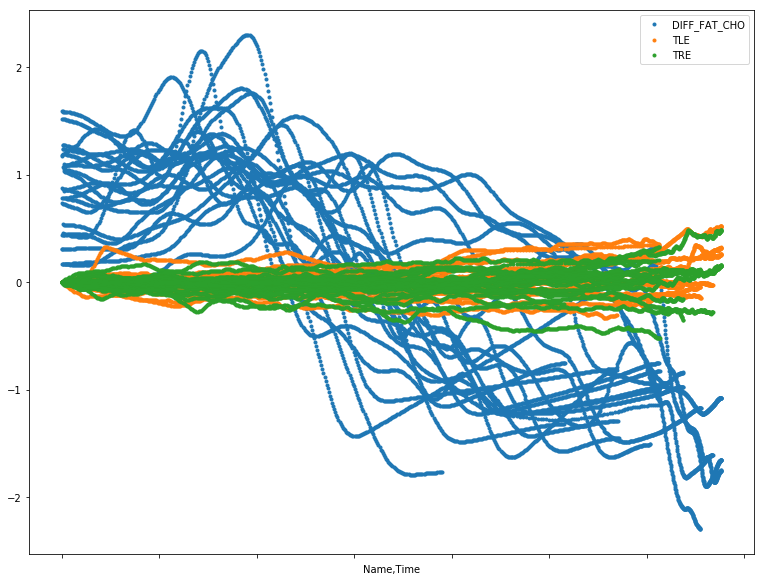

In [28]:
full_df_norm[["DIFF_FAT_CHO","TLE","TRE"]].sort_index(level = "Time").plot(style='.')

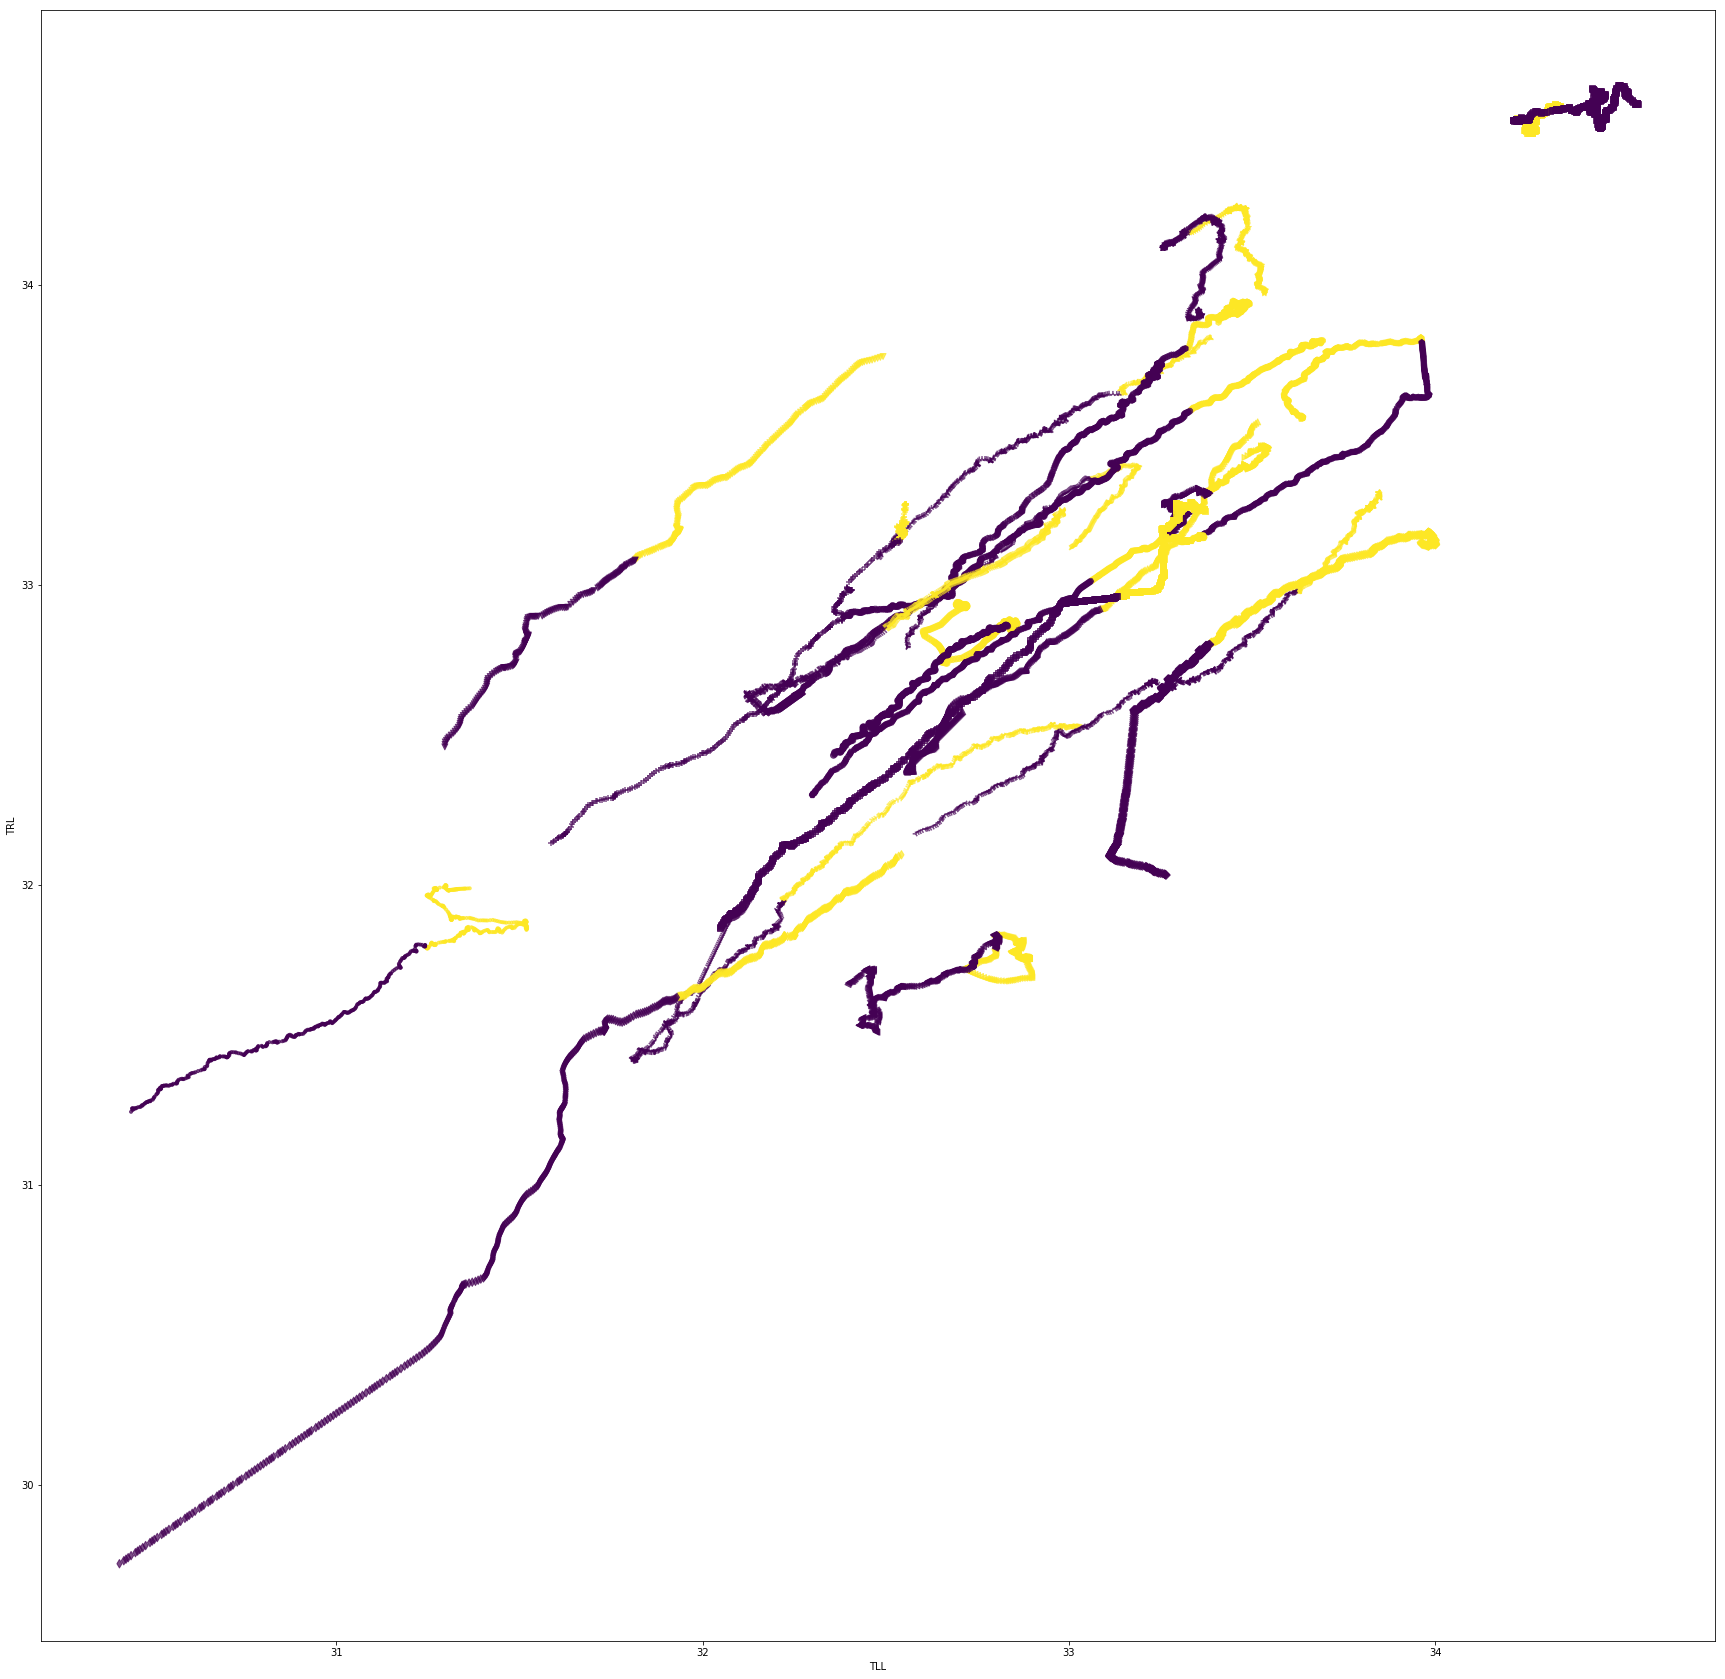

In [29]:
markers = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', '*', 'h', 
     'H', '+', 'x', 'D', 'd']
plt.rcParams["figure.figsize"] = [30,30]
for n,i in enumerate(markers):
    plt.xlabel("TLL")
    plt.ylabel("TRL")
    plot = plt.scatter(np.array(full_df.xs(subjects[n])["TLA"]), np.array(full_df.xs(subjects[n])["TRA"]), c=full_df.xs(subjects[n])["y"],  marker=i, alpha = 0.7)

#plot.figure.savefig("./plots/all_arms_plots.png")


# save filtered data

In [30]:
 full_df.to_pickle("./data/data_first_measurement.pkl") 